In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [37]:
list(data.columns)

['latitude',
 'longitude',
 'geo_precision',
 'fatalities',
 'users',
 'frac',
 'month',
 'missing_data',
 'Exchange rate USD',
 'Unemployment rate',
 'Rule of law index (-2.5 weak; 2.5 strong)',
 'Government effectiveness index (-2.5 weak; 2.5 strong)',
 'Control of corruption (-2.5 weak; 2.5 strong)',
 'Regulatory quality index (-2.5 weak; 2.5 strong)',
 'Voice and accountability index (-2.5 weak; 2.5 strong)',
 'Political stability index (-2.5 weak; 2.5 strong)',
 'Corruption Perceptions Index 100 = no corruption',
 'Political rights index 7 (weak) - 1 (strong)',
 'Civil liberties index 7 (weak) - 1 (strong) ',
 'Short-term political risk (1=low 7=high)',
 'Medium/long-term political risk (1=low 7=high)',
 'Political violence risk (1=low 7=high)',
 'Mobile phone subscribers per 100 people',
 'Property rights index (0-100)',
 'Freedom from corruption index (0-100)',
 'Business freedom index (0-100)',
 'Labor freedom index (0-100)',
 'Life expectancy in years',
 'Fragile state index 0

In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [3]:
df.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
0,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Egypt),unknown,3,unknown,unknown,0,30,Northern Africa,Egypt,Cairo,Al Maadi,unknown,Cairo-Al Maadi,29.9667,31.2500,1,0,1578503454,MA,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
1,2017-01-01,2017,Battles,Armed clash,Military Forces of Iraq (2014-2018) Popular Mo...,unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Anbar,Anah,unknown,Aradi as Sakrah,34.1915,42.0313,3,6,1567462133,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
2,2017-01-01,2017,Explosions/Remote violence,Air/drone strike,Military Forces of Iraq (2014-2018),unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Ninewa,Mosul,unknown,Mosul,36.3350,43.1189,1,20,1572403769,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
3,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Islamic State (Iraq),unknown,2,Civilians (Iraq),unknown,7,27,Middle East,Iraq,Najaf,Najaf,unknown,Najaf,32.0259,44.3462,2,6,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
4,2017-01-01,2017,Battles,Armed clash,Islamic State (Iraq),unknown,2,Police Forces of Iraq (2014-2018),unknown,1,12,Middle East,Iraq,Najaf,Manathera,unknown,Al Mishkhab,31.8044,44.4893,1,0,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1


In [4]:
data = df.loc[df['country'] == 'Egypt', :]

In [5]:
data.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
0,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Egypt),unknown,3,unknown,unknown,0,30,Northern Africa,Egypt,Cairo,Al Maadi,unknown,Cairo-Al Maadi,29.9667,31.2500,1,0,1578503454,MA,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
86,2017-01-02,2017,Protests,Protest with intervention,Police Forces of Egypt (2014-),unknown,1,Protesters (Egypt),Journalists (Egypt); Lawyers (Egypt),6,16,Northern Africa,Egypt,Cairo,Qasr al Nile,unknown,Cairo-Qasr al Nile,30.0488,31.2343,1,0,1578503456,CU,654,54,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
87,2017-01-02,2017,Protests,Protest with intervention,Police Forces of Egypt (2014-),unknown,1,Protesters (Egypt),Nubian Ethnic Group (Egypt),6,16,Northern Africa,Egypt,Aswan,Aswan,unknown,Aswan,24.0911,32.8973,1,0,1561469096,CU,654,54,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,3
169,2017-01-03,2017,Battles,Armed clash,Police Forces of Egypt (2014-),unknown,1,Unidentified Armed Group (Egypt),unknown,3,13,Northern Africa,Egypt,Fayoum,Abshaway,unknown,Ibsheway,29.3570,30.6437,1,1,1561469096,MA,598,59,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
349,2017-01-05,2017,Battles,Armed clash,Police Forces of Egypt (2014-),unknown,1,Hasam Movement,unknown,3,13,Northern Africa,Egypt,Giza,Giza,unknown,6th October City,29.9464,30.9169,1,1,1552577122,MA,508,59,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0


In [6]:
data.shape

(1719, 58)

In [7]:
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [8]:
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [9]:
df.head()

,date,count
0,2019-05-21,16
1,2017-03-07,15
2,2019-09-27,14
3,2019-03-01,10
4,2018-02-17,10


In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [12]:
data.head()

,event_date,event_type,admin1,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,date,count
0,2017-01-01,Explosions/Remote violence,Cairo,29.9667,31.2500,1,0,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0,2017-01-01,1
1,2017-01-02,Protests,Cairo,30.0488,31.2343,1,0,654,54,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0,2017-01-02,2
2,2017-01-02,Protests,Aswan,24.0911,32.8973,1,0,654,54,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,3,2017-01-02,2
3,2017-01-03,Battles,Fayoum,29.3570,30.6437,1,1,598,59,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0,2017-01-03,1
4,2017-01-05,Battles,Giza,29.9464,30.9169,1,1,508,59,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0,2017-01-05,1


In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Alexandria,admin1_Assiut,admin1_Aswan,admin1_Behera,admin1_Beni Suef,admin1_Cairo,admin1_Dakahlia,admin1_Damietta,admin1_Fayoum,admin1_Gharbia,admin1_Giza,admin1_Ismailia,admin1_Kafr El-Shikh,admin1_Kalyoubia,admin1_Luxor,admin1_Matrouh,admin1_Menia,admin1_Menoufia,admin1_New Valley,admin1_North Sinai,admin1_Port Said,admin1_Qena,admin1_Red Sea,admin1_Sharkia,admin1_South Sinai,admin1_Suez,admin1_Suhag
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,29.9667,31.2500,1,0,564,56,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,30.0488,31.2343,1,0,654,54,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-02,24.0911,32.8973,1,0,654,54,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,3,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-03,29.3570,30.6437,1,1,598,59,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-05,29.9464,30.9169,1,1,508,59,1,0.0,18.6331,11.74,-0.540,-0.62,-0.55,-0.860,-1.250,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.710,97.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-29,30.0771,31.2859,2,0,750,55,12,0.0,16.0819,10.76,-0.475,-0.60,-0.57,-0.865,-1.265,-1.29,35,6,6,3,5,5,101.03,37,29,66,52,71.74,88.4,8.2,8.6,4.3,10.0,6.7,31.96,48.12,42.705,98.0,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-30,31.1316,33.7984,1,1,727,54,12,0.0,16.0819,10.76,-0.475,-0.60,-0.57,-0.865,-1.265,-1.29,35,6,6,3,5,5,101.03,37,29,66,52,71.74,88.4,8.2,8.6,4.3,10.0,6.7,31.96,48.12,42.705,98.0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2019-12-30,31.2160,34.

In [16]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [17]:
y = data['count']
X = data.drop(columns=['count'])


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
minmax = MinMaxScaler()

In [20]:
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [21]:
X_train.shape

(1289, 39)

In [31]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [32]:
batch_x, batch_y = train[0]

In [33]:
batch_x.shape

(64, 3, 39)

In [34]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(64, activation='relu', kernel_regularizer=regularizers.l1(1e-5),return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.7))
# Second LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# Third LSTM layer
model.add(LSTM(units=64, kernel_regularizer=regularizers.l1(1e-5),activation='relu', return_sequences=True))
model.add(Dropout(0.7))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 64)             26624     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)              

In [35]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=20)

Epoch 1/20
21/21 [==============================] - 1s 63ms/step - loss: 93.7060 - val_loss: 92.1569
Epoch 2/20
21/21 [==============================] - 0s 7ms/step - loss: 64.7627 - val_loss: 86.0458
Epoch 3/20
21/21 [==============================] - 0s 8ms/step - loss: 58.3015 - val_loss: 78.0667
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 54.5334 - val_loss: 76.6614
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 54.7623 - val_loss: 74.6521
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 53.1271 - val_loss: 69.0362
Epoch 7/20
21/21 [==============================] - 0s 8ms/step - loss: 53.6713 - val_loss: 70.9297
Epoch 8/20
21/21 [==============================] - 0s 8ms/step - loss: 52.5999 - val_loss: 64.8546
Epoch 9/20
21/21 [==============================] - 0s 7ms/step - loss: 52.0023 - val_loss: 65.8716
Epoch 10/20
21/21 [==============================] - 0s 7ms/step - loss: 52.5251 - val_loss: 60.912

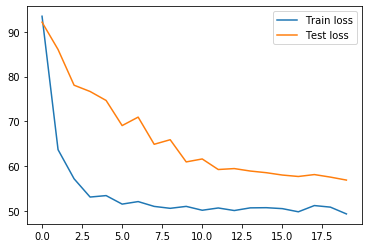

In [36]:

plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend();

In [37]:
preds = model.predict(test)

In [38]:
preds

array([[36.381706],
       [35.81288 ],
       [38.41641 ],
       ...,
       [33.302006],
       [33.088448],
       [33.088318]], dtype=float32)